# Shock finding in a moving mesh - RICH radiation hydrodynamics
[Schaal & Springel, 2015](https://arxiv.org/abs/1407.4117), [Schaal et al, 2016](https://arxiv.org/abs/1604.07401)

## Step 1: flag the shock zones
According to these three criteria
$$
\begin{gather}
\partial_i v^i < 0
\\
\partial^i T \partial_i p > 0
\\
\partial^i\partial_i \log T \geq \log \left. \frac{T_2}{T_1} \right|_{\mathcal{M}_\mathrm{min}}
\\
\partial^i\partial_i \log p \geq \log \left. \frac{p_2}{p_1} \right|_{\mathcal{M}_\mathrm{min}}
\end{gather}
$$

In [1]:
%load_ext autoreload
%autoreload 2
import os

import numpy as np
import h5py
import matplotlib.pyplot as plt
import unyt as u
import math

import richio
richio.plots.use_nice_style()

In [2]:
!ls /home/hey4/rich_tde/data/raw/

ApptainerTDER1M1BH10000beta2S60n3ComptonLowResNewAMRRemoveCenter
N1e6TDER1M1BH10000beta2S60n3ComptonLowResNewAMRRemoveCenter
NewbuildTDER1M1BH10000beta2S60n3ComptonLowResNewAMRRemoveCenter
SedovDissipation
SedovDissipationGrad
ShockTubeN1e3IdealGas
ShockTubeN1e3OndrejEOS
ShockTubeN1e4IdealGas
ShockTubePL100PR1e-3N1e3
ShockTubePL10PR1e-2N1e3
ShockTubePL1e3PR1e-4N1e3
ShockTubePR1e-2N1e3IdealGas
ShockTubeSodN1e3Lbox2
etc
sedov2d
sedov2dMPI
sedov3d
sedov3dMPI


In [3]:
snap_dir = '/home/hey4/rich_tde/data/raw/SedovDissipationGrad'
# snap_dir = '/home/hey4/RICH-fwrk/build/'
!ls $snap_dir

sedov_0.h5   sedov_100.h5   sedov_50.h5   sedov_final.h5
sedov_0.vtu  sedov_100.vtu  sedov_50.vtu  sedov_final.vtu


In [4]:
snap = richio.load(os.path.join(snap_dir, 'sedov_100.h5'))

/zfsstore/user/hey4/rich_tde/richio/richio/data.py:55: UserWarning: No snapshot number found in path: /home/hey4/rich_tde/data/raw/SedovDissipationGrad/sedov_100.h5
  warnings.warn(f"No snapshot number found in path: {self.path}")


In [5]:
snap.info()

                                     RICH SNAPSHOT INFORMATION                                      

Snapshot Details                        
----------------------------------------------------------------------------------------------------
  Path                      : /home/hey4/rich_tde/data/raw/SedovDissipationGrad/sedov_100.h5
  Snapshot Number           : -1
  Time                      : [0.0042907] code_time
  Box size                  : [-1. -1. -1.  1.  1.  1.] code_length
  Cycle                     : [100.] dimensionless
  Number of Ranks           : 1

Available Fields                         [Unit System: RICH]
----------------------------------------------------------------------------------------------------
Field           Unit                                     Aliases
----------------------------------------------------------------------------------------------------
Box             code_length                              box_size, box, boxsize
CMx             co

/zfsstore/user/hey4/rich_tde/richio/richio/units.py:117: UserWarning: 'Eg_0' is in the data output but not used in the simulation.
  warnings.warn(f"'{key}' is in the data output but not used in the simulation.")


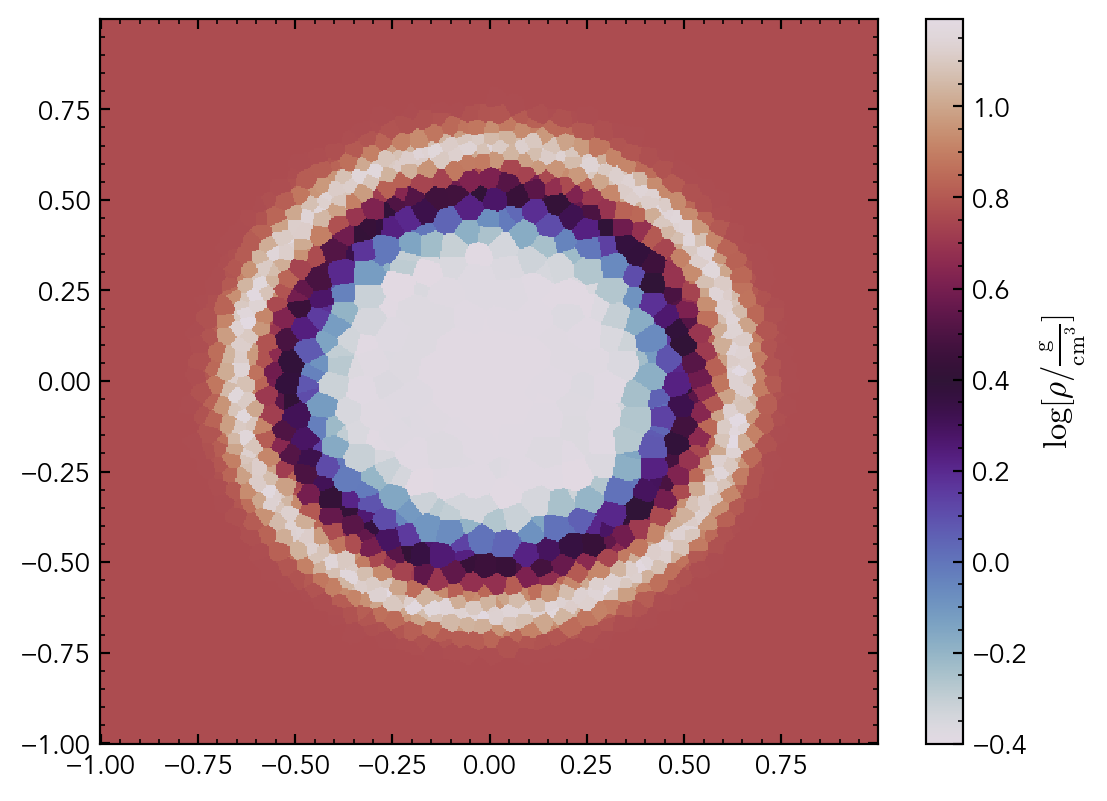

In [6]:
ax, im, data = snap.plots.peek()
plt.show()

In [7]:
def shock_direction(grad_T):
    """Find the shock direction given temperature gradient.
    d_s = - grad_T / |grad_T|
    """
    norm_grad_T = np.linalg.norm(grad_T, axis=1, keepdims=True)

    # For small magnitudes, set ds to zero
    ds = - grad_T / norm_grad_T

    ds[norm_grad_T < 1e-3] = 0 # TODO: accommodate for units
    # ds = np.where(norm_grad_T < 1e-3, np.zeros_like(grad_T), - grad_T / norm_grad_T)

    return ds

In [8]:
# First condition
condition1 = snap.divV < 0

In [9]:
rho = snap.density
rho = np.where(condition1, rho, rho * 0)

In [10]:
isinstance(rho, u.unyt_array)

True

In [12]:
sliced_rho, xspace, yspace = snap.slice(rho, res=256, slice_coord=0, unit_system='rich')

/home/hey4/.conda/envs/richanalysis/lib/python3.13/site-packages/unyt/array.py:1832: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


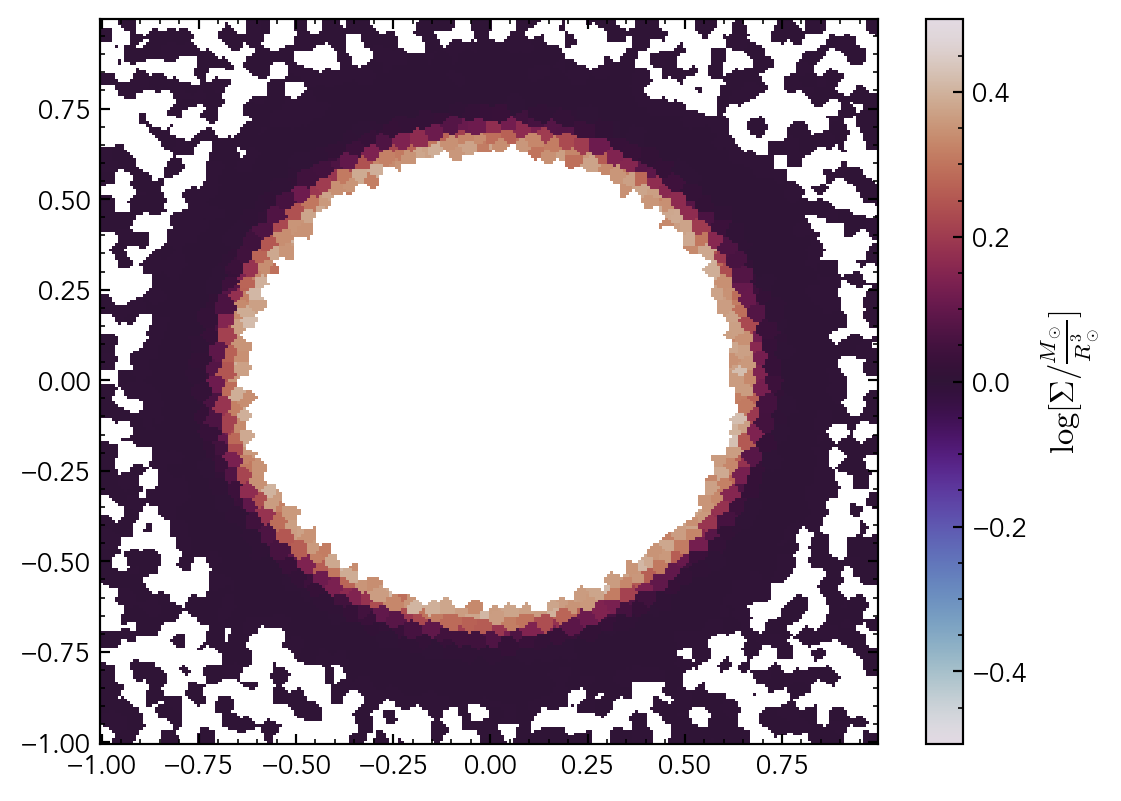

In [14]:
ax, im = richio.plots.scalar_map(f=sliced_rho, xspace=xspace, yspace=yspace)
plt.show()

In [17]:
grad_P = np.stack([snap.DpDx, snap.DpDy, snap.DpDz], axis=-1)

In [20]:
grad_rho = np.stack([snap.DrhoDx, snap.DrhoDy, snap.DrhoDz], axis=-1)

In [ ]:
grad_T = 

In [ ]:
def searching_tree(tree, point):
    _, idx = tree.query(point)
    return idx

def find_prepost(sim_tree, X, Y, Z, point, ds, delta, direction):
    """ Find the previous/next point along the shock direction by moving in
    the shock direction by steps of distance `delta` each time and 

    Parameters
    -----------
    point: array.
        Starting point.
    ds: array (1x3)
        Shock direction.
    delta: float.
        Step to do to search.
    direction: str.
        Choose if you want to move towards the 'pre' or 'post' shock region.
    Returns
    -----------
    idx: int.
        Tree index of the previous/next point along the shock direction.
    """
    if direction == 'post':
        delta = - delta
        
    k = 0
    # check that you are not taking the same point as the one given
    distance = 0

    while distance == 0:
        k += 1
        new_point = point + k * delta * ds 
        idx  = searching_tree(sim_tree, new_point) # sim_tree.query(new_point)
        new_point = np.array([X[idx], Y[idx], Z[idx]])
        distance = math.dist(point, new_point)

    final_step = k*np.abs(delta)

    return idx, final_step

## Step 2: shock surface
This involves a "ray tracing" step

In [ ]:
def find_T_mach(T2_T1, gamma):
    """ Find mach number from the temperature jump (T2_T1). """
    a = 2*gamma*(gamma-1)
    minusb = gamma*2-6*gamma + T2_T1*(gamma+1)**2 + 1
    M2 = (minusb + np.sqrt(minusb**2 + 8*a*(gamma-1))) / (2*a)
    return np.sqrt(M2)

def find_P_mach(P2_P1, gamma):
    """ Find mach number from the pressure jump (P2_P1). """
    M2 = (P2_P1*(gamma+1)+gamma-1) / (2*gamma)
    return np.sqrt(M2)

def find_rho_mach(rho2_rho1, gamma):
    """ Find mach number from the density jump (rho2_rho1). """
    M2 = 2*rho2_rho1 / (gamma+1-rho2_rho1*(gamma-1))
    return np.sqrt(M2)